In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lib.function import MO_generator
from scipy.linalg import expm

In [15]:
T = 30
dt = 1 # time increment, unit: 1 minute of 1 year
decimal_place = 5 # decimal places specified in the market
sigma = 0.3 # Annual volitility of the asset
Midprice = 10 # Initial price of the asset

# Posted LO is filled with probability of e^(-kappa*depth)
kappa_sell , kappa_buy = 10**2 , 10**2
kappa = 10**2
# Arrival rate of selling MOs from other participants in market
lambda_sell = 1
# Arrival rate of buying MOs from other participants in market
lambda_buy = 1
lamda = 1
# Inventory boundary
q_upper = 30
q_lower = -30
# Risk aversion parameters
alpha = 10**-4
phi = 1*10**-5
t = np.linspace(0,T,T+1).astype(int)
length = len(t)


h = np.zeros([length , q_upper-q_lower+1])
delta_buy = np.zeros([length , q_upper-q_lower])
delta_sell = np.zeros([length , q_upper-q_lower])

# Let A denote a square matrix
A = np.zeros([q_upper-q_lower+1, q_upper-q_lower+1])
z = np.zeros(q_upper-q_lower+1)

# Notice we assume kappa_buy = kappa_sell in the model
# i denotes the column number
for i in range(q_upper-q_lower+1):
    # j denotes the row number
    for j in range(q_upper-q_lower+1):
        if j == i:
            # q = q_upper - j
            A[j,i] = - phi*kappa_buy*(q_upper-j)**2
        elif j == i-1:
            A[j,i] = lambda_buy*np.e**-1
        elif j == i+1:
            A[j,i] = lambda_sell*np.e**-1

for i in range(q_upper-q_lower+1):
    # q = q_upper - i
    z[i] = np.exp(-alpha*kappa_buy*(q_upper-i)**2)

    
for i in range(length):
    h[i] = np.log(np.dot(expm(A*(T-i*dt)),z))/kappa_buy

for j in range(q_upper-q_lower):
    # q = q_upper - j
    delta_sell[:,j] = 1/kappa_buy + h[:,j] - h[:,j+1]

for j in range(q_upper-q_lower):
    # q = q_upper -1 - j
    delta_buy[:,j] = 1/kappa_sell + h[:,j+1] - h[:,j]

delta_buy = np.round(delta_buy,decimal_place)
delta_sell = np.round(delta_sell,decimal_place)

In [23]:
# Simulate result
value = []
Cash = []
Price = []
Inventory = []
iterations = 5000
for iteration in range(iterations):
    S = np.zeros(length)
    X = np.zeros(length)
    Q = np.zeros(length)
    dW = np.sqrt(dt)*np.random.randn(length-1)
    S[0] = 10
    X[0] = 500
    Q[0] = 0

    for i in range(length-1):
        S[i+1] = S[i] + sigma*dW[i]

    for i in range(length-1):
        # current position
        q = int(Q[i])

        delta_sell_current = delta_sell[i,q_upper-q]
        delta_buy_current = delta_buy[i,q_upper-q-1]

        dN_sell = np.random.poisson(lamda*np.exp(-kappa*delta_sell_current)*dt)
        dN_buy = np.random.poisson(lamda*np.exp(-kappa*delta_buy_current)*dt)
        # Cash process

        X[i+1] = X[i] + (S[i]+delta_sell_current)*dN_sell - (S[i]-delta_buy_current)*dN_buy
        # Inventory process
        Q[i+1] = Q[i] + dN_buy - dN_sell
    Cash.append(X)
    Price.append(S)
    Inventory.append(Q)
    # calculate value function
    value.append(X[-1] + Q[-1]*(S[-1]-alpha*Q[-1]) - np.sum([phi*dt*Q[i]**2 for i in range(length-1)]))

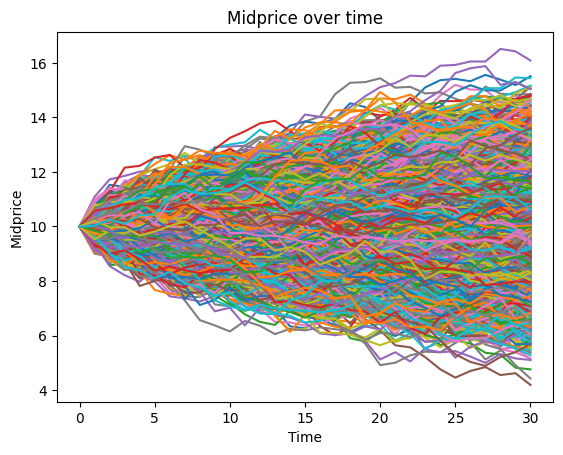

In [24]:
fig,ax = plt.subplots()

for i in range(iterations):
    ax.plot(Price[i])


ax.set_ylabel('Midprice')
ax.set_xlabel('Time')
ax.set_title('Midprice over time')
plt.show()

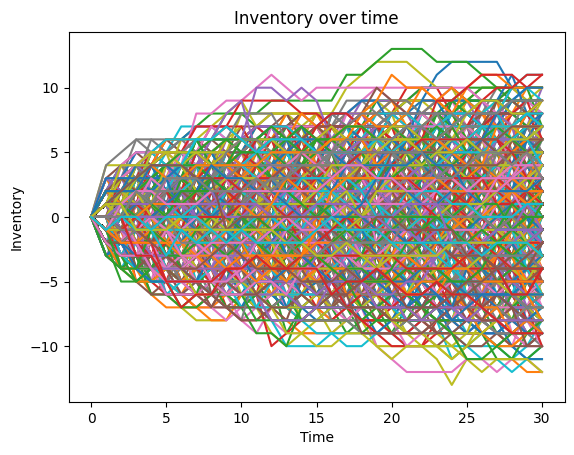

In [25]:
fig,ax = plt.subplots()

for i in range(iterations):
    ax.plot(Inventory[i])


ax.set_ylabel('Inventory')
ax.set_xlabel('Time')
ax.set_title('Inventory over time')
plt.show()

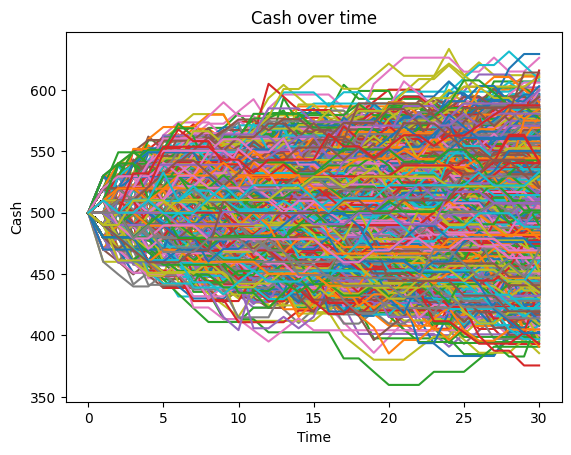

In [26]:
fig,ax = plt.subplots()

for i in range(iterations):
    ax.plot(Cash[i])


ax.set_ylabel('Cash')
ax.set_xlabel('Time')
ax.set_title('Cash over time')
plt.show()

In [55]:
# set parameter
T = 10
time_decimal = 3
dt = 1 / 10**time_decimal 
t = np.linspace(0, T, T*10**time_decimal+1)
t = np.round(t, time_decimal)

lambda_buy =  50
lambda_sell = 50
kappa = 10
q_upper = 20 
q_lower = -20 
phi = 1*10**-5
spread = 0.04

sigma = 1
s0 = 10
x0 = 100

# Dynamic process
length = len(t)
dW = np.sqrt(dt)*np.random.randn(length-1)
S = np.zeros(length) # Midprice
S[0] = s0
Q = np.zeros(length) # Inventory
Q[0] = q_upper
X = np.zeros(length) # Cash
X[0] = x0

# generate coming MO in time [0,T]
MOs_time = MO_generator(
    period=T,
    buy_mo_intensity=lambda_buy,
    sell_mo_intensity=lambda_sell,
    time_decimal=time_decimal,
)

In [56]:
for time_step in range(1, length):
    S[time_step] = S[time_step-1] + sigma*dW[time_step-1]
    
    # MO coming
    if t[time_step] in MOs_time.index.values:
        # determine the depth of MM strategy
        buy_depth = np.inf 
        sell_depth = 0.25 if Q[time_step-1] > q_lower else np.inf

        if MOs_time.loc[t[time_step]][0] == 'sell':
            # sell MO coming, judge if the sell MO hits MM's buy LO
            prob = np.exp(- buy_depth * kappa)
            dN_t = np.random.binomial(1, prob)
            # inventory process jumps 
            Q[time_step] = Q[time_step-1] + dN_t
            # cash jumps
            if dN_t == 0:
                X[time_step] = X[time_step-1]
            else:
                X[time_step] = X[time_step-1] - (S[time_step-1] - buy_depth) * dN_t
            
        else:
            # buy MO coming
            prob = np.exp(- sell_depth * kappa)
            dN_t = np.random.binomial(1, prob)
            # inventory process jump 
            Q[time_step] = Q[time_step-1] - dN_t
            # cash jumps
            if dN_t == 0:
                X[time_step] = X[time_step-1]
            else:
                X[time_step] = X[time_step-1] + (S[time_step-1] + sell_depth) * dN_t

    # No MO coming
    else:
        X[time_step] = X[time_step-1]
        Q[time_step] = Q[time_step-1]



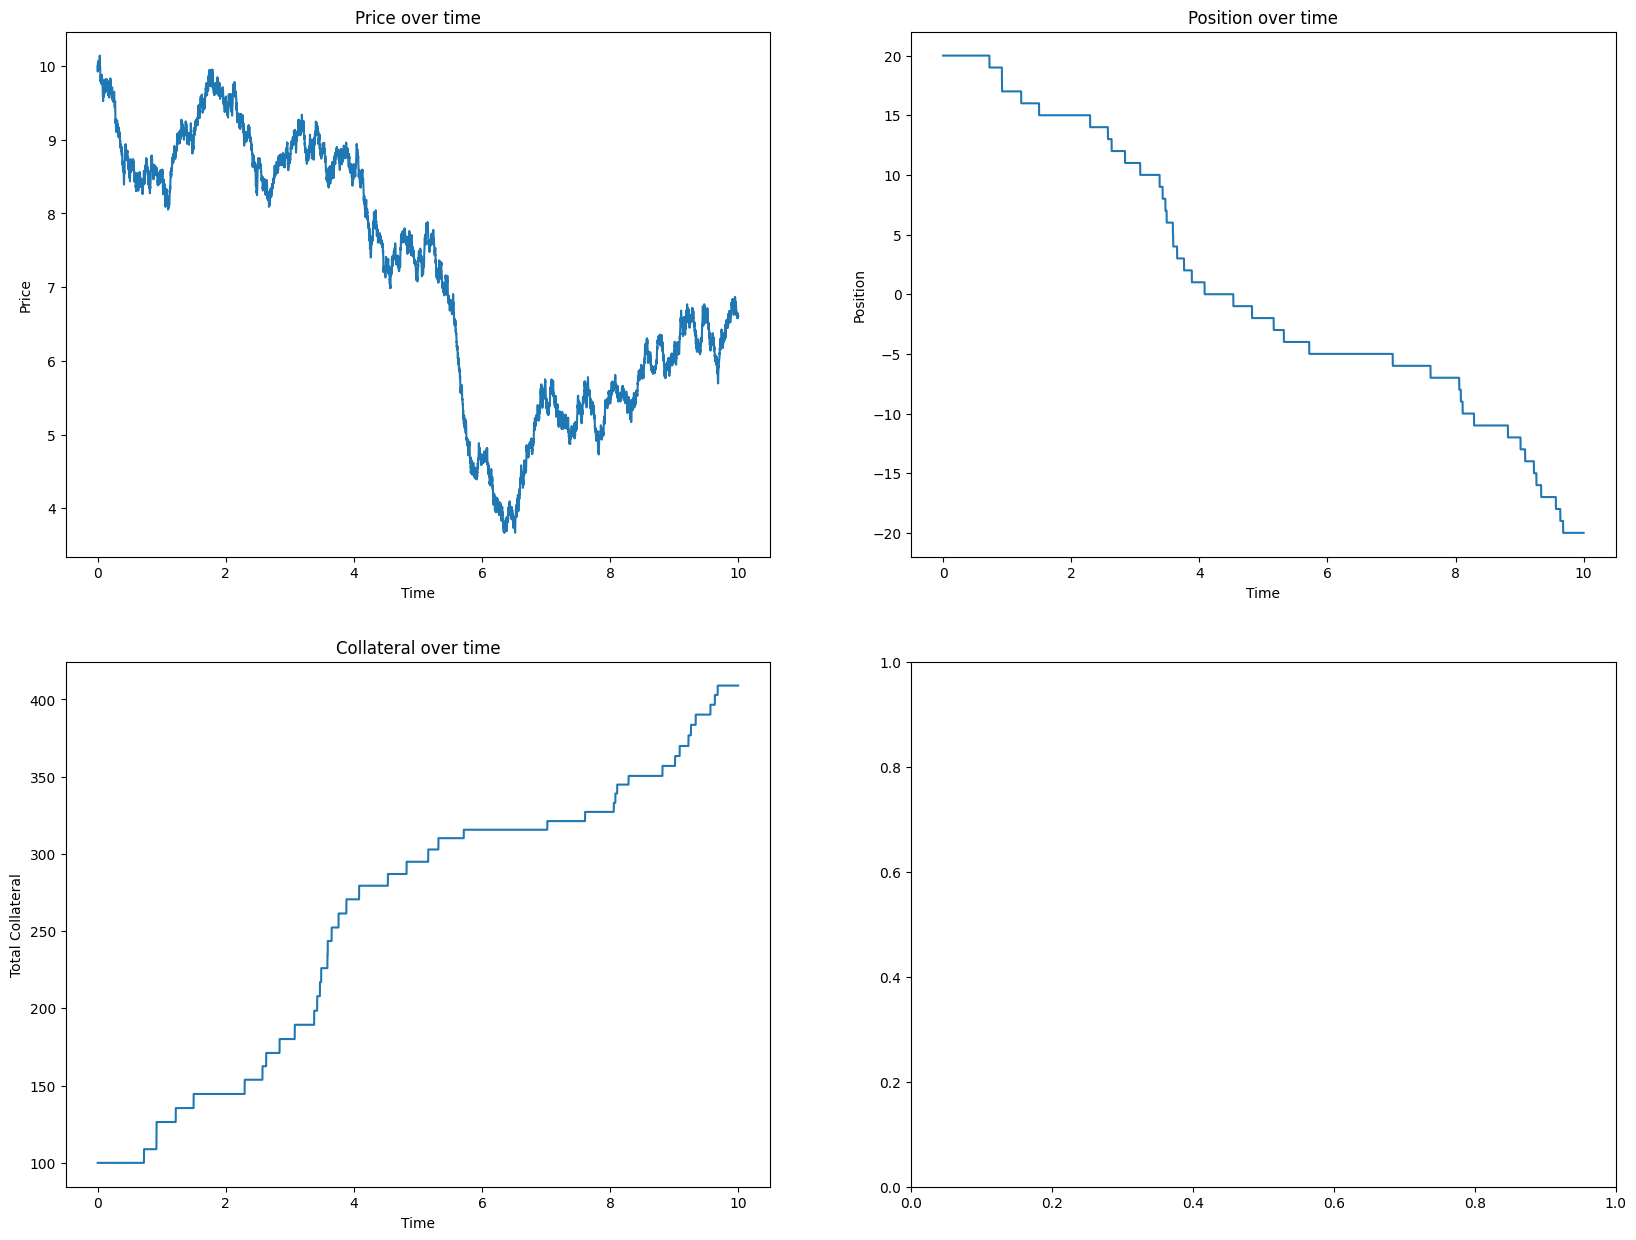

In [57]:
# Plot the performance

# Plot markprice & midprice
fig,ax = plt.subplots(2,2,figsize=(20,15))

ax[0,0].plot(t, S, label='midprice')
ax[0,0].set_title('Price over time')
ax[0,0].set_xlabel("Time")
ax[0,0].set_ylabel("Price")

ax[0,1].plot(t, Q)
ax[0,1].set_title('Position over time')
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylabel("Position")

ax[1,0].plot(t, X)
ax[1,0].set_title('Collateral over time')
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("Total Collateral")

plt.show()